Goal of this notebook is to create a plain feed forward NNs with the MNIST dataset using keras tensorflow.

In [1]:
# Load the main library needed for this assignment
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Layer


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Data Preparation
* Load MNIST dataset from keras
* Flatten and normalize the grayscale by dividing by 255 on the training and testing data
* One-hot encode training and testing labels

In [49]:
from keras.datasets import mnist

# Load MNIST dataset from keras
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Number of samples
n = 10000
# Normalize training data
random_index = np.random.randint(n, size=n) # Pick training data randomly
train_images, labels = (X_train[random_index]/255, Y_train[random_index])

# Convert train label into one-hot encoding
train_labels = np.zeros((len(labels),10))
for i,l in enumerate(labels):
    train_labels[i][l] = 1

# Flatten the testing data 
test_images = X_test.reshape(len(X_test),28*28)
test_images = test_images/255 # If Normalization

# If Standarization
#test_images = (test_images - np.mean(test_images))/ np.std(test_images)

test_labels = np.zeros((len(Y_test),10)) # one-hot encode test labels
for i,l in enumerate(Y_test):
    test_labels[i][l] = 1

print(f'Train Data: {train_images.shape}, Train Label: {train_labels.shape}, Test Data: {test_images.shape}, Test Label: {test_labels.shape}')

Train Data: (10000, 28, 28), Train Label: (10000, 10), Test Data: (10000, 784), Test Label: (10000, 10)


### Visualization

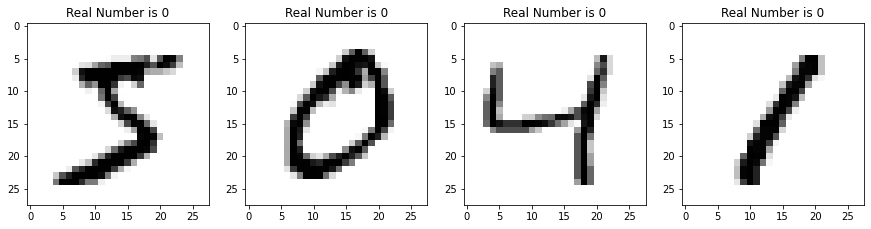

In [38]:
fig, axis = plt.subplots(1, 4, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train[i], cmap='binary')
    digit = Y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


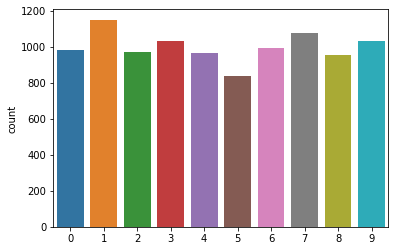

In [50]:
# Distribution of training labels
sns.countplot(Y_train[random_index])

# Building 3 layer Feed Forward NN with pure Numpy

### Linear Model
* Initialize the random weights of network properly
* Compute forward pass and calculate the gradient for backward pass
* Update weights and bias


In [5]:
class Linear(Layer):
  """y = w.x + b"""

  def __init__(self, units=32):
      super(Linear, self).__init__()
      self.units = units

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b

### Dropout

A regularization method of randomly turning off neruours during training. Prevent overfitting by enforcing the neural network to train exclusively using random subsections (smaller network) of the neural network.
* Make use of Bernoulli distribution s.t. for a rate of 80%, each value in dropout_mask is 1 and 20% of the time, it's 0. 

In [6]:
class Dropout(Layer):
  
  def __init__(self, rate):
    super(Dropout, self).__init__()
    self.rate = rate

  def call(self, inputs, training=None):
    if training:
      return tf.nn.dropout(inputs, rate=self.rate)
    return inputs

### Custom Model Configuration
* Build stack of linear layers with dropout for regularization and ReLU as activation function

In [7]:
class MLP(Layer):

    def __init__(self):
        super(MLP, self).__init__()
        self.linear_1 = Linear(784)
        self.dropout = Dropout(0.5)
        self.linear_2 = Linear(200)
        self.dropout = Dropout(0.5)
        self.linear_3 = Linear(80)
        self.dropout = Dropout(0.5)
        self.linear_4 = Linear(10)

    def call(self, inputs, training=None):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)
        x = self.linear_3(x)
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)
        return self.linear_4(x)

### Image Augmentation
* Perform augmentation on training dataset to prevent overfitting
* Make use of Keras ImageDataGenerator Techniques: 
    - Randomly rotate images by 15 degree
    - Randomly zoom by 20% 
    - Randomly shift images horizontally and vertically by 20%
* Guide on applying: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [8]:
# Code from Kaggle Notebook - MNIST: Simple CNN keras (Accuracy : 0.99)=>Top 1%
# Source: https://www.kaggle.com/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1#4.-Evaluate-the-model

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

<Figure size 432x288 with 0 Axes>

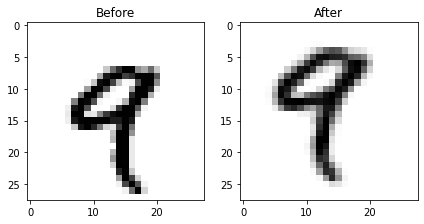

In [9]:
sample_image = train_images[4:5]
sample = datagen.flow(np.expand_dims(sample_image,3), train_labels[:1])

plt.figure()
f, ax = plt.subplots(1,2,figsize=(7, 7))
ax[0].imshow(sample_image[0], cmap='binary')
ax[0].set_title('Before')
ax[1].imshow(np.squeeze(np.squeeze(sample.next()[0],axis=0)), cmap='binary')
ax[1].set_title('After')
plt.show()

### Training and Testing
* **Mini-batch gradient descent** with appropriate learning rate
* Make use of **Image Data Generator** pipeline to conduct mini-batch
    * In every epoch, it applies augmentation randomly on batches of data
* Flatten and **normalize** the grayscale by dividing by 255 on the training data after image augmentation
* Implement adaptive learning rate by using **Adam** for optimizer
    * Combine the method of AdaGrad and RMSProp and use the exponential moving averages of the gradient and the squared gradient. (https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/#:~:text=Adam%20is%20a%20replacement%20optimization,sparse%20gradients%20on%20noisy%20problems.)

In [10]:
def train_on_batch(x,y):  
  with tf.GradientTape() as tape:
    y_pred = mlp(x, training=True) # Forward Pass
    loss = mse_loss_fn(y, y_pred) # Compute loss
    loss += sum(mlp.losses) # Add regularization loss
  grads = tape.gradient(loss, mlp.trainable_weights) # Use autograd to compute gradient
  optimizer.apply_gradients(zip(grads, mlp.trainable_weights)) # Update learnable parameter
  return loss

def eval_step(y, y_pred):
  loss = mse_loss_fn(y,y_pred)
  pred, real = np.argmax(y_pred,1), np.argmax(y,1) # Argmax returns the indices of the max value
  accuracy = np.sum(pred == real)/len(y)
  return loss, accuracy

In [45]:
def fit(x, y, x_test, y_test, model, opt, loss_fn, num_epochs: int, batch_size):
  Train_Loss, Train_Acc, Test_Loss, Test_Acc = [], [], [], []
  for epoch in range(num_epochs):
    batches = 0
    # Train using batches from Image Augmentation Generator 
    # Reshape input to have rank 4 for generator 
    for x_batch, y_batch in datagen.flow(np.expand_dims(x,3), y, batch_size=batch_size):
      loss = train_on_batch(x_batch.reshape(len(x_batch),28*28),y_batch)
      batches += 1
      if batches >= len(x) / batch_size:
        break # we need to break the loop by hand because the generator loops indefinitely
    if epoch % 100 == 0:
      # Train Dataset
      print('Epoch', epoch)
      train_loss, train_acc = eval_step(y, model(x.reshape(len(x),28*28), training=False))
      print(f'Train Loss {train_loss}, Train Accuracy {train_acc}')
      Train_Loss.append(train_loss)
      Train_Acc.append(train_acc)
      # Test Dataset
      test_loss, test_acc = eval_step(y_test, model(x_test, training=False))
      print(f'Test Loss {test_loss}, Test Accuracy {test_acc}')
      Test_Loss.append(test_loss)
      Test_Acc.append(test_acc)
      print()
  return Train_Loss, Train_Acc, Test_Loss, Test_Acc

# Define Learning Rate, Optimizer, Loss
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # Optimizer
mse_loss_fn = tf.keras.losses.MeanSquaredError() # Loss Function
mlp = MLP() # Initialize Model
Train_Loss, Train_Acc, Test_Loss, Test_Acc = fit(train_images, train_labels, test_images, test_labels, model=mlp, opt=optimizer, loss_fn=mse_loss_fn, num_epochs=401, batch_size=512)

Epoch 0
Train Loss 0.09018508344888687, Train Accuracy 0.1619
Test Loss 0.09001079201698303, Test Accuracy 0.1681

Epoch 100
Train Loss 0.007268599700182676, Train Accuracy 0.96715
Test Loss 0.007313606329262257, Test Accuracy 0.9657

Epoch 200
Train Loss 0.006421444471925497, Train Accuracy 0.97365
Test Loss 0.00662230234593153, Test Accuracy 0.9721

Epoch 300
Train Loss 0.00543890381231904, Train Accuracy 0.97455
Test Loss 0.005558710545301437, Test Accuracy 0.9735

Epoch 400
Train Loss 0.005552447400987148, Train Accuracy 0.9772
Test Loss 0.005841373465955257, Test Accuracy 0.9744



# Model Evaluation 

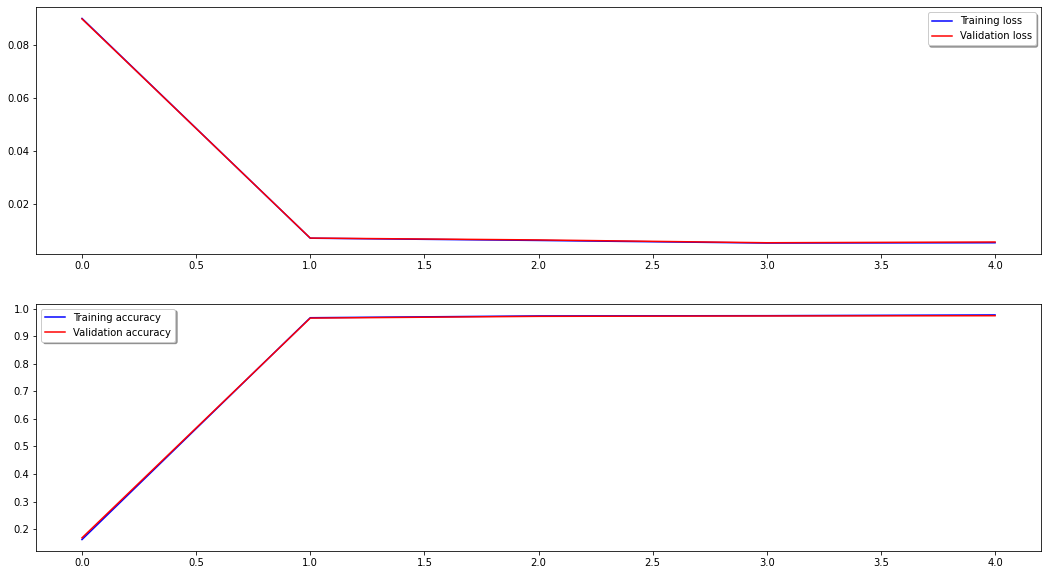

In [46]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(Train_Loss, color='b', label="Training loss")
ax[0].plot(Test_Loss, color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(Train_Acc, color='b', label="Training accuracy")
ax[1].plot(Test_Acc, color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Confusion Matrix

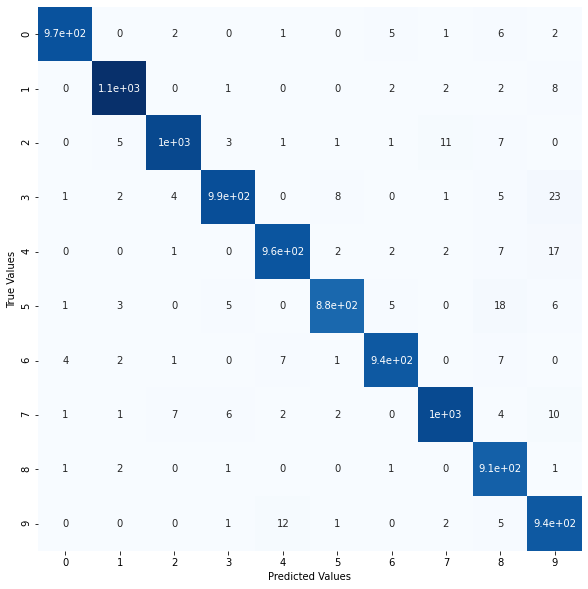

In [47]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = mlp(test_images, training=False) # Predict encoded label as 2 => [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(test_labels, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

### Prediction Visualization

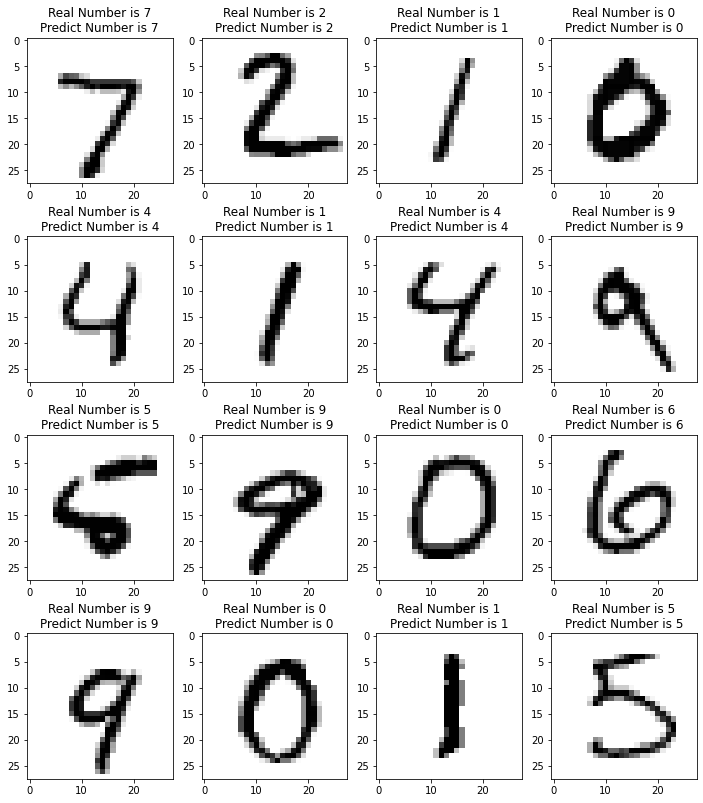

In [48]:
fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test[i], cmap='binary')
    ax.set(title = f"Real Number is {Y_test[i]}\nPredict Number is {Y_pred[i]}");